In [128]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [129]:
%cd 'drive/MyDrive/Classroom/Machine Learning 2565-1/Project'

[Errno 2] No such file or directory: 'drive/MyDrive/Classroom/Machine Learning 2565-1/Project'
/content/drive/MyDrive/Classroom/Machine Learning 2565-1/Project


In [130]:
!pip install keras-tuner

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [131]:
import pandas as pd
import datetime
import numpy as np
import seaborn as sns
from scipy import stats,mean
import keras
from keras.models import Sequential
from keras.layers import Dropout,Dense,LSTM,Flatten
from keras.callbacks import EarlyStopping
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error,r2_score
from keras_tuner import RandomSearch
import joblib

In [132]:
return_period=1

In [133]:
def plotStockPrice(actual,predict,timestep,name):
  plt.figure(figsize=(8,4), dpi= 100, facecolor='w', edgecolor='k')
  plt.plot(actual, color='red', label = 'Actual Closing Price')
  plt.plot(predict, color='green', label = 'Predicted Closing Price')
  plt.title(name+' Actual vs Predicted - Stock Closing Price '+timestep)
  plt.xlabel('Index')
  plt.ylabel('Stock Price')
  plt.legend(loc='best')
  plt.show()

  plt.figure(figsize=(8,4), dpi= 100, facecolor='w', edgecolor='k')
  plt.scatter(actual, predict)
  plt.xlabel("actual")
  plt.ylabel("predicted")
  plt.title(name+' Scatter plot - actual vs predicted '+timestep)
  plt.show()
def showResult(x_test,y_test,descript,model,timestep,name):
  pred=model.predict(x_test)
  r2_model_before_tuning=r2_score(np.array(y_test), pred)
  print('R2 score '+descript+':',r2_model_before_tuning)
  mse_model_before_tuning=mean_squared_error(np.array(y_test), pred)
  print('mean_squared_error '+descript+':',mse_model_before_tuning)

  plotStockPrice(np.array(y_test),pred,timestep,name)
  return pred,r2_model_before_tuning,mse_model_before_tuning

In [134]:
def prepareDataForLR(x_df,y_df,return_period):
  y_df=y_df.shift(-return_period)
  y_df=y_df.iloc[:-(return_period) , :]
  x_df=x_df.iloc[:-(return_period) , :]
  return x_df,y_df

In [135]:
n_steps=24
def prepareDataForLSTM(x_df,y_df,n_steps,return_period):
  x_df=np.array(x_df)
  y_df=np.array(y_df)
  x,y=[],[]
  for i in range(len(x_df)-n_steps-return_period+1):
    x.append(x_df[i:i+n_steps,:])
    y.append(y_df[(i+n_steps)+return_period-1,-1])
  x=np.array(x)
  y=np.array(y)
  return x,y


In [136]:
x_test=pd.read_csv('x_df_test.csv')
y_test=pd.read_csv('y_df_test.csv')

In [137]:

x_test.drop(['Unnamed: 0'], axis=1,inplace=True)
x_test

,stock_close,stock_volume,spy_close,spy_volume,overall_sentiment_score
0,-1.856947,-0.485026,0.607829,-0.609489,0.726702
1,-1.862836,-0.491651,0.604673,-0.618948,0.743402
2,-1.857437,-0.495648,0.617297,-0.623680,0.743402
3,-1.863327,-0.494190,0.629133,-0.618703,0.743402
4,-1.865291,-0.497252,0.617297,-0.610727,0.743402
...,...,...,...,...,...
523,-2.071438,-0.493728,-0.077044,-0.624992,-0.264481
524,-2.071929,-0.489831,-0.075466,-0.625192,-0.264481
525,-2.072905,-0.497403,-0.077833,-0.625360,-0.264481
526,-2.074874,-0.494690,-0.070732,-0.612320,-0.264481


In [138]:

y_test.drop(['Unnamed: 0'], axis=1,inplace=True)
y_test

,stock_close
0,95.0900
1,94.9700
2,95.0800
3,94.9600
4,94.9200
...,...
523,90.7200
524,90.7100
525,90.6901
526,90.6500


# Linear Regression

In [139]:
x_lr_test,y_lr_test=prepareDataForLR(x_test,y_test,return_period)

In [140]:
lr_model = joblib.load('best_lr.sav')

In [141]:
lr_model.get_params()

{'copy_X': True,
 'fit_intercept': True,
 'n_jobs': None,
 'normalize': True,
 'positive': True}

R2 score after tuning: 0.9845539985823931
mean_squared_error after tuning: 0.04239951523837966


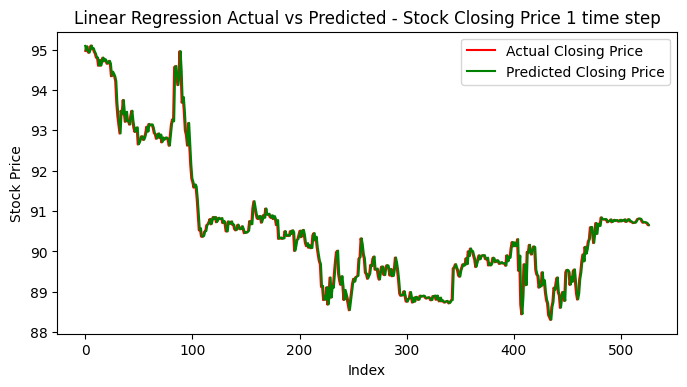

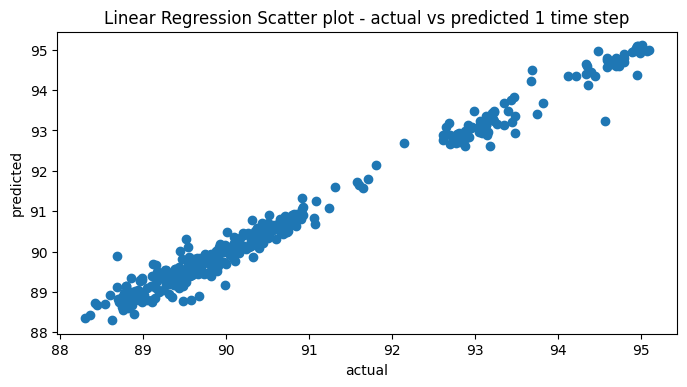

In [142]:
lr_pred_1,r2_lr_best_1,mse_lr_best_1=showResult(x_lr_test,y_lr_test,'after tuning',lr_model,str(return_period)+' time step','Linear Regression')

# LSTM

In [143]:
x_lstm_test,y_lstm_test=prepareDataForLSTM(x_test,y_test,n_steps,return_period)

In [144]:
lstm_model=keras.models.load_model('checkpoint_lstm_full_trained')

In [145]:
lstm_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 24, 24)            2880      
                                                                 
 dropout (Dropout)           (None, 24, 24)            0         
                                                                 
 lstm_1 (LSTM)               (None, 24, 18)            3096      
                                                                 
 dropout_1 (Dropout)         (None, 24, 18)            0         
                                                                 
 lstm_2 (LSTM)               (None, 24, 12)            1488      
                                                                 
 dropout_2 (Dropout)         (None, 24, 12)            0         
                                                                 
 lstm_3 (LSTM)               (None, 18)                2

16/16 [==============================] - 3s 12ms/step
R2 score after tuning: -5.227177613742257
mean_squared_error after tuning: 12.533622229842353


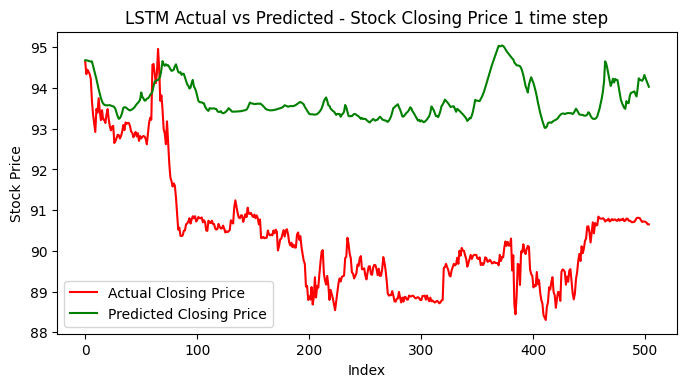

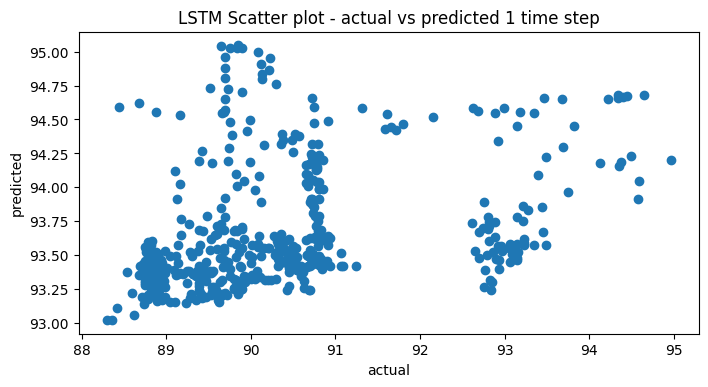

In [146]:
lstm_pred_1,r2_lstm_best_1,mse_lstm_best_1=showResult(x_lstm_test,y_lstm_test,'after tuning',lstm_model,str(return_period)+' time step','LSTM')

In [147]:
model_R2=[r2_lr_best_1,r2_lstm_best_1]
model_MSE=[mse_lr_best_1,mse_lstm_best_1]

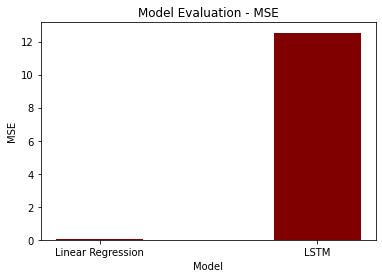

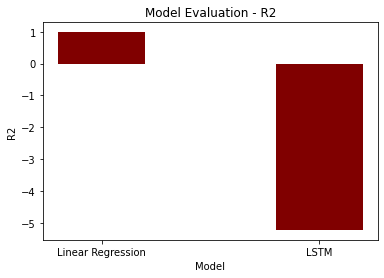

In [148]:
model_label=["Linear Regression","LSTM"]
metrics_label=['MSE','R2']
metrics=[model_MSE,model_R2]
for i in range(len(metrics)):
  # creating the bar plot
  plt.bar(model_label, metrics[i], color ='maroon',width = 0.4)
 
  plt.xlabel("Model")
  plt.ylabel(metrics_label[i])
  plt.title('Model Evaluation - '+metrics_label[i])
  plt.show()